In [102]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models  import model_from_json
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import glob
import easyocr
import pytesseract
from PIL import Image

In [103]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Model Loaded successfully")
        return model
    except Exception as e:
        print(e)

In [104]:
# Pre-trained model source: https://github.com/ksingh7/ml_experiments/tree/main/convert_keras_model_to_tensorflow
wpod_net_path = "./models/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Model Loaded successfully


In [105]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

In [106]:
def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

1/1 [==============================] - 0s 125ms/step


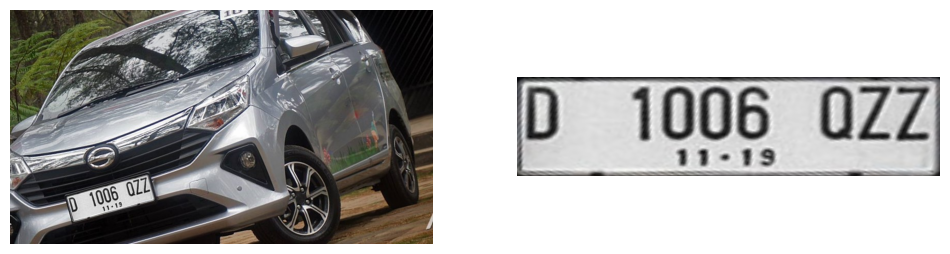

In [120]:
test_image_path = "dataset/plate6.jpg"
vehicle, LpImg, cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

In [121]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

In [122]:
# reader = easyocr.Reader(['en'])
# result = reader.readtext(LpImg)
# result
# reader = easyocr.Reader(['en'])
# result = reader.readtext(LpImg[0])
# np_img = np.squeeze(LpImg[0], axis=2) 
img = interval_mapping(LpImg[0], 0.0, 1.0, 0, 255)
# pytesseract.pytesseract.tesseract_cmd = 'C:\Program Files\Tesseract-OCR\\tesseract'
# text = pytesseract.image_to_string(np.uint8(img))
# plt.imshow(np.uint8(img))
# print(np.uint8(img))

reader = easyocr.Reader(['en'])
result = reader.readtext(np.uint8(img))
result


# if len(result) > 1:
#     for elmt in result:
        


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 3], [55, 3], [55, 77], [0, 77]], 'D', 0.971006623293281),
 ([[116, 0], [290, 0], [290, 78], [116, 78]], '1006', 0.9999533891677856),
 ([[327, 0], [470, 0], [470, 83], [327, 83]], 'OZZ', 0.6821150224753958),
 ([[169, 75], [291, 75], [291, 103], [169, 103]],
  '11419',
  0.23117889683202436)]